# Modelo 6 Multiclase

## Importacion de librerias:

In [7]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50 #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [8]:
class ImageDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.class_names = ['plaga', 'sana', 'otros', 'Animales']  # Orden consistente
        
    def load_data(self):
        """Carga datos con validación mejorada"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"⚠️  Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                # Filtrar solo archivos de imagen
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx)  # Usar índice consistente
                    class_count += 1
                    total_images += 1
            
            class_counts[label] = class_count
            print(f"📊 Clase '{label}': {class_count} imágenes")
        
        print(f"📈 Total de imágenes cargadas: {total_images}")
        
        # Verificar balance de clases
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"⚠️  Desbalance detectado: ratio {ratio:.2f}:1")
                print("💡 Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"❌ Error al cargar {img_path}: {e}")
            return None

In [14]:
class ResNetModelImproved:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.class_names = ['plaga', 'sana', 'otros', 'animales']
        self.model = None
        self.history = None
        
    def build_model(self):
        """Construye modelo con arquitectura optimizada"""
        # Cargar ResNet50 preentrenado
        base_model = ResNet50(
            weights='imagenet', 
            include_top=False, 
            input_shape=(224, 224, 3)
        )
        
        # CORRECCIÓN: Congelar capas iniciales, descongelar las últimas 15
        for layer in base_model.layers[:-25]:
            layer.trainable = False
        
        for layer in base_model.layers[-25:]:
            layer.trainable = True
        
        print(f"🔧 Capas entrenables: {sum([1 for layer in base_model.layers if layer.trainable])}")
        print(f"🔒 Capas congeladas: {sum([1 for layer in base_model.layers if not layer.trainable])}")
        
        # Arquitectura mejorada con menos capas densas
        self.model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Reducida regularización
            layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Reducida regularización
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        return self.model
    
    def compile_model(self, initial_lr=0.0001):
        """Compila modelo con configuración optimizada"""

        
        optimizer = Adam(learning_rate=0.0001)
        
        # Métricas corregidas para multiclase
        metrics = [
            'accuracy',
            Precision(name='precision_macro'),
            Recall(name='recall_macro'),
            AUC(name='auc', multi_label=False),  # CORRECCIÓN: multi_label=False para multiclase
        ]
        
        # Métricas por clase individual
        for i, class_name in enumerate(self.class_names):
            metrics.extend([
                Precision(class_id=i, name=f'precision_{class_name}'),
                Recall(class_id=i, name=f'recall_{class_name}')
            ])
        
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=metrics
        )
        
        print("✅ Modelo compilado exitosamente")
        return self.model
    
    def get_callbacks(self, model_name='best_leaf_model.h5'):
        """Define callbacks optimizados"""
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,  # Más paciencia
                restore_best_weights=False,
                verbose=1
            ),
        ]
        
        return callbacks
    
    def calculate_class_weights(self, labels):
        """Calcula pesos para balancear clases"""
        unique_labels = np.unique(labels)
        class_weights = compute_class_weight(
            'balanced',
            classes=unique_labels,
            y=labels
        )
        
        class_weight_dict = dict(zip(unique_labels, class_weights))
        print("⚖️  Pesos de clase calculados:")
        for i, weight in class_weight_dict.items():
            print(f"   {self.class_names[i]}: {weight:.3f}")
        
        return class_weight_dict
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, use_class_weights=True):
        """Entrena modelo con configuración optimizada"""
        
        # Calcular pesos de clase si se especifica
        class_weight = None
        if use_class_weights:
            labels_numeric = np.argmax(y_train, axis=1)
            class_weight = self.calculate_class_weights(labels_numeric)
        
        
        print("🚀 Iniciando entrenamiento...")
        print(f"📊 Épocas: {epochs}, Batch size: {batch_size}")
        
        self.history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=self.get_callbacks(),
            verbose=1
        )
        
        return self.history
    
    def evaluate_detailed(self, X_test, y_test):
        """Evaluación detallada del modelo"""
        print("🧪 Evaluando modelo...")
        
        # Predicciones
        predictions = self.model.predict(X_test)
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Métricas básicas
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)[:2]
        print(f"📊 Loss: {loss:.4f}")
        print(f"📊 Accuracy: {accuracy:.4f}")
        
        # Reporte de clasificación
        print("\n📋 Reporte de Clasificación:")
        print("=" * 60)
        report = classification_report(y_true, y_pred, target_names=self.class_names)
        print(report)
        
        # Matriz de confusión
        cm = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix(cm)
        
        # Métricas por clase
        print("\n📈 Métricas Detalladas por Clase:")
        print("=" * 60)
        for i, class_name in enumerate(self.class_names):
            class_mask = y_true == i
            if np.sum(class_mask) > 0:
                class_acc = np.mean(y_pred[class_mask] == y_true[class_mask])
                class_samples = np.sum(class_mask)
                
                # Confianza promedio para predicciones correctas
                correct_predictions = y_pred[class_mask] == y_true[class_mask]
                if np.sum(correct_predictions) > 0:
                    avg_confidence = np.mean(np.max(predictions[class_mask][correct_predictions], axis=1))
                else:
                    avg_confidence = 0
                
                print(f"{class_name.upper()}:")
                print(f"  📊 Muestras: {class_samples}")
                print(f"  🎯 Accuracy: {class_acc:.4f}")
                print(f"  🔍 Confianza: {avg_confidence:.4f}")
                print()
        
        return {
            'loss': loss,
            'accuracy': accuracy,
            'predictions': predictions,
            'y_pred': y_pred,
            'y_true': y_true,
            'classification_report': report
        }
    
    def plot_confusion_matrix(self, cm):
        """Visualiza matriz de confusión"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Matriz de Confusión', fontsize=16)
        plt.xlabel('Predicción', fontsize=12)
        plt.ylabel('Verdadero', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def plot_training_history(self):
        """Visualiza historial de entrenamiento"""
        if not self.history:
            print("❌ No hay historial de entrenamiento disponible")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Historial de Entrenamiento', fontsize=16)
        
        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Entrenamiento', linewidth=2)
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validación', linewidth=2)
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Entrenamiento', linewidth=2)
        axes[0, 1].plot(self.history.history['val_loss'], label='Validación', linewidth=2)
        axes[0, 1].set_title('Loss')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Precision
        if 'precision_macro' in self.history.history:
            axes[1, 0].plot(self.history.history['precision_macro'], label='Entrenamiento', linewidth=2)
            axes[1, 0].plot(self.history.history['val_precision_macro'], label='Validación', linewidth=2)
            axes[1, 0].set_title('Precision (Macro)')
            axes[1, 0].set_xlabel('Época')
            axes[1, 0].set_ylabel('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Recall
        if 'recall_macro' in self.history.history:
            axes[1, 1].plot(self.history.history['recall_macro'], label='Entrenamiento', linewidth=2)
            axes[1, 1].plot(self.history.history['val_recall_macro'], label='Validación', linewidth=2)
            axes[1, 1].set_title('Recall (Macro)')
            axes[1, 1].set_xlabel('Época')
            axes[1, 1].set_ylabel('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath='modelo_hojas_optimizado.h5'):
        """Guarda el modelo"""
        self.model.save(filepath)
        print(f"💾 Modelo guardado en: {filepath}")


In [9]:
"""Pipeline principal optimizado"""
print("🌱 Clasificador de Hojas Optimizado")
print("=" * 50)
    
# 1. Cargar datos
data_dir = 'data/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()
    
if not dataset.images:
    print("❌ No se cargaron imágenes. Verifica la estructura de carpetas.")
    exit(1)
    
# 2. Preparar datos
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_cat = to_categorical(labels, num_classes=4)
    
print(f"\n📊 Datos preparados:")
print(f"   Imágenes: {images.shape}")
print(f"   Etiquetas: {labels_cat.shape}")
    
# 3. División estratificada
X_train, X_val, y_train, y_val = train_test_split(
        images, labels_cat, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )
    
print(f"\n🔄 División de datos:")
print(f"   Entrenamiento: {X_train.shape[0]} imágenes")
print(f"   Validación: {X_val.shape[0]} imágenes")

🌱 Clasificador de Hojas Optimizado
📊 Clase 'plaga': 1557 imágenes
📊 Clase 'sana': 1526 imágenes
📊 Clase 'otros': 1597 imágenes
📊 Clase 'Animales': 1564 imágenes
📈 Total de imágenes cargadas: 6244

📊 Datos preparados:
   Imágenes: (6244, 224, 224, 3)
   Etiquetas: (6244, 4)

🔄 División de datos:
   Entrenamiento: 4995 imágenes
   Validación: 1249 imágenes


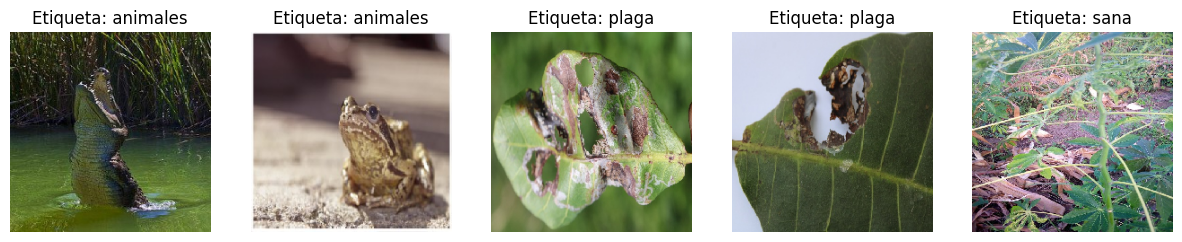

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Número de imágenes a seleccionar
num_imagenes = 5

# Seleccionar índices aleatorios sin reemplazo
indices_aleatorios = np.random.choice(len(X_val), size=num_imagenes, replace=False)

# Mostrar las imágenes seleccionadas con sus etiquetas
clases = ['plaga', 'sana', 'otros', 'animales']

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices_aleatorios):
    img = X_val[idx]
    etiqueta_onehot = y_val[idx]
    etiqueta = np.argmax(etiqueta_onehot)

    plt.subplot(1, num_imagenes, i + 1)
    plt.imshow(img)
    plt.title(f"Etiqueta: {clases[etiqueta]}")
    plt.axis('off')

plt.show()

In [11]:
import numpy as np

# Ver frecuencia por clase en validación
counts = np.bincount(np.argmax(y_val, axis=1))
print("Distribución de clases en validación:", counts)


Distribución de clases en validación: [311 305 320 313]


In [12]:
model = ResNetModelImproved(num_classes=4)
model.build_model()
model.compile_model(initial_lr=0.0001)

# Mostrar resumen
model.model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
🔧 Capas entrenables: 25
🔒 Capas congeladas: 150
✅ Modelo compilado exitosamente


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,809,540 (94.64 MB)

 Trainable params: 11,211,972 (42.77 MB)

 Non-trainable params: 13,597,568 (51.87 MB)

In [15]:
history = model.train(
        X_train, y_train, X_val, y_val,
        epochs=10,  # Reducido para prueba inicial
        batch_size=16,
        use_class_weights=True
    )

⚖️  Pesos de clase calculados:
   plaga: 1.002
   sana: 1.023
   otros: 0.978
   animales: 0.998
🚀 Iniciando entrenamiento...
📊 Épocas: 10, Batch size: 16
Epoch 1/10
294/312 ━━━━━━━━━━━━━━━━━━━━ 11s 626ms/step - accuracy: 0.7448 - auc: 0.9143 - loss: 2.0295 - precision_animales: 0.7330 - precision_macro: 0.8013 - precision_otros: 0.8182 - precision_plaga: 0.8459 - precision_sana: 0.8143 - recall_animales: 0.6312 - recall_macro: 0.6735 - recall_otros: 0.6208 - recall_plaga: 0.7092 - recall_sana: 0.7348

c:\Users\juan0\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 220s 704ms/step - accuracy: 0.7452 - auc: 0.9146 - loss: 2.0253 - precision_animales: 0.7329 - precision_macro: 0.8016 - precision_otros: 0.8186 - precision_plaga: 0.8461 - precision_sana: 0.8150 - recall_animales: 0.6320 - recall_macro: 0.6743 - recall_otros: 0.6217 - recall_plaga: 0.7100 - recall_sana: 0.7356 - val_accuracy: 0.6998 - val_auc: 0.9094 - val_loss: 1.9138 - val_precision_animales: 0.9592 - val_precision_macro: 0.7664 - val_precision_otros: 0.8966 - val_precision_plaga: 1.0000 - val_precision_sana: 0.5854 - val_recall_animales: 0.4505 - val_recall_macro: 0.6093 - val_recall_otros: 0.7312 - val_recall_plaga: 0.3376 - val_recall_sana: 0.9213
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 250s 802ms/step - accuracy: 0.8027 - auc: 0.9487 - loss: 1.6903 - precision_animales: 0.7995 - precision_macro: 0.8442 - precision_otros: 0.8399 - precision_plaga: 0.8623 - precision_sana: 0.8695 - recall_animales: 0.6935 - recall_macro: 0.7526 - recall_otros: 0.7114 -

🧪 Evaluando modelo...
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 604ms/step
📊 Loss: 1.0688
📊 Accuracy: 0.8151

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

       plaga       0.75      0.94      0.83       311
        sana       0.82      0.89      0.86       305
       otros       0.92      0.72      0.81       320
    animales       0.81      0.71      0.76       313

    accuracy                           0.82      1249
   macro avg       0.82      0.82      0.81      1249
weighted avg       0.82      0.82      0.81      1249



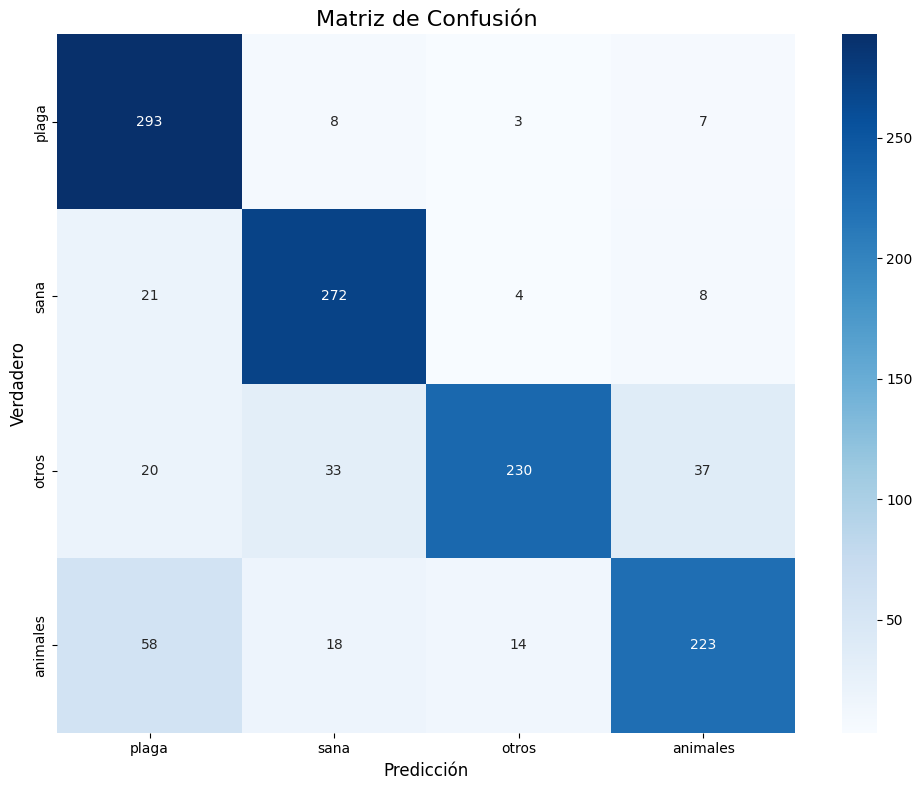


📈 Métricas Detalladas por Clase:
PLAGA:
  📊 Muestras: 311
  🎯 Accuracy: 0.9421
  🔍 Confianza: 0.9744

SANA:
  📊 Muestras: 305
  🎯 Accuracy: 0.8918
  🔍 Confianza: 0.9658

OTROS:
  📊 Muestras: 320
  🎯 Accuracy: 0.7188
  🔍 Confianza: 0.9379

ANIMALES:
  📊 Muestras: 313
  🎯 Accuracy: 0.7125
  🔍 Confianza: 0.8691



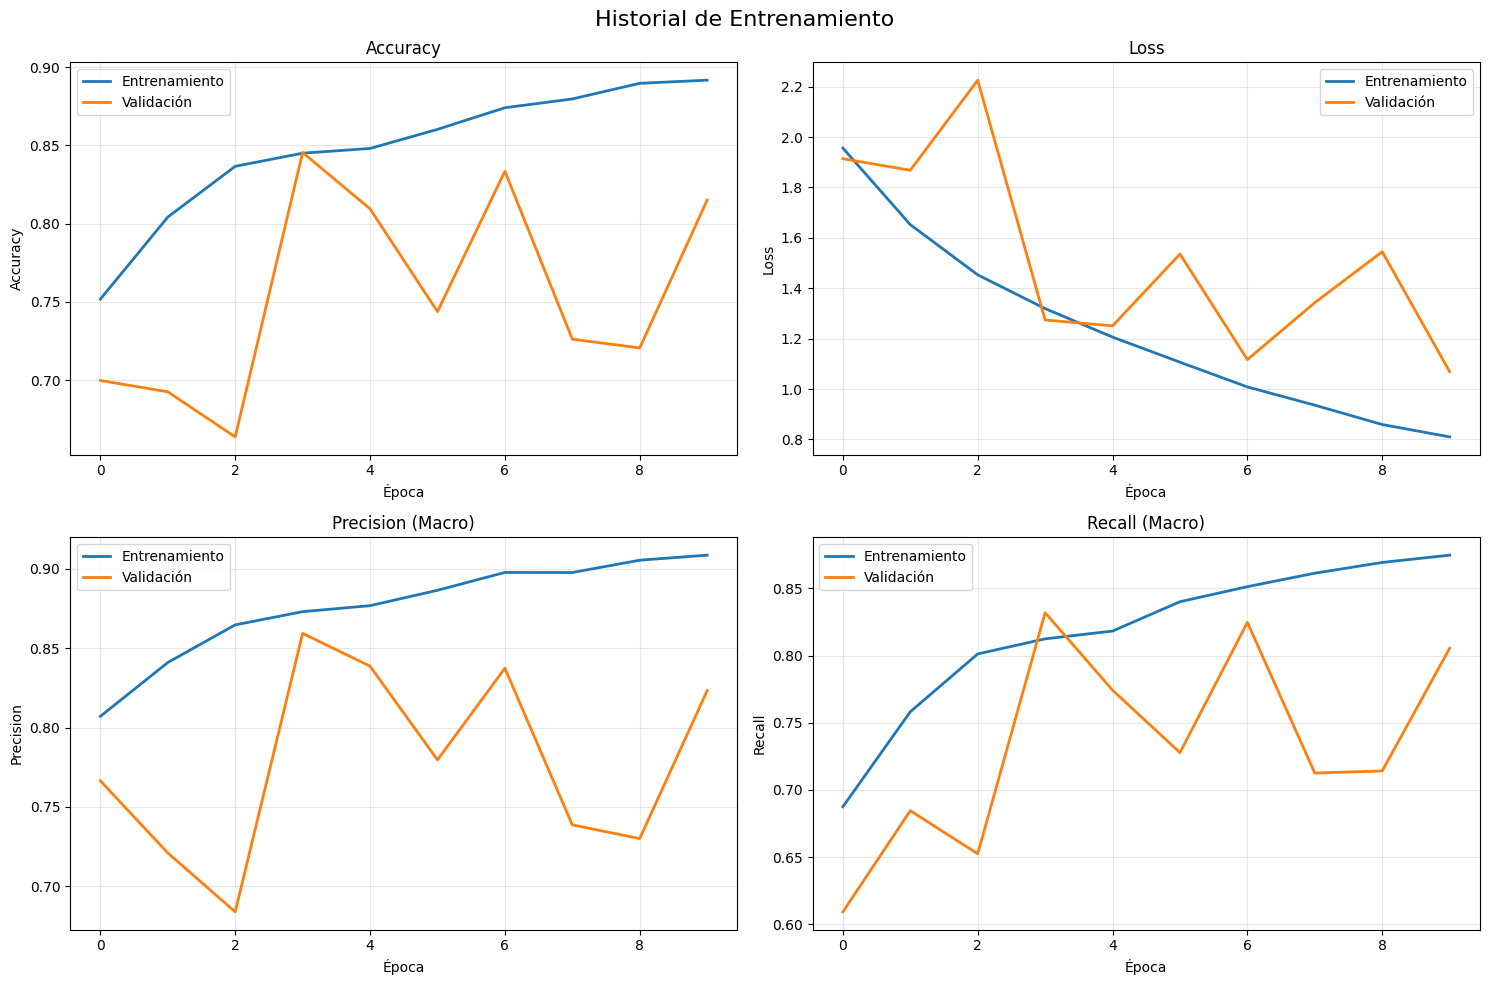

In [16]:
results = model.evaluate_detailed(X_val, y_val)
model.plot_training_history()

In [16]:

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


GPUs disponibles: []


In [17]:
import numpy as np

# Predecir probabilidades
y_pred_probs = model.model.predict(X_val)

# Obtener etiquetas predichas (índice de la clase con mayor probabilidad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales (de one-hot a etiqueta numérica)
y_true = np.argmax(y_val, axis=1)


 8/40 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step

KeyboardInterrupt: 

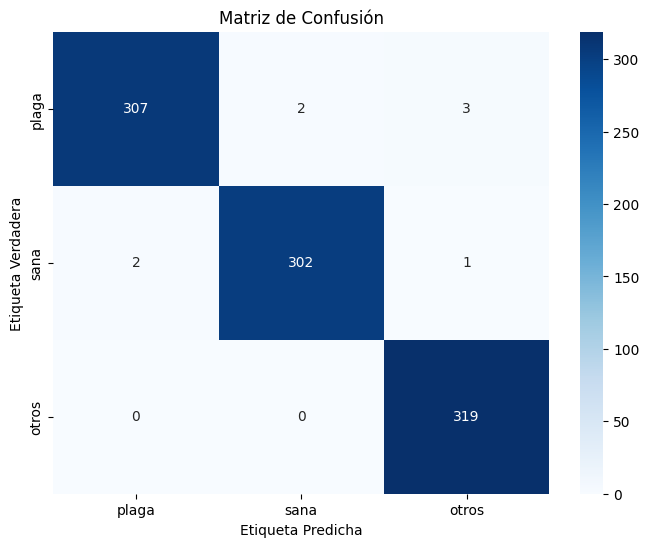

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Etiquetas de las clases
class_names = ['plaga', 'sana', 'otros']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


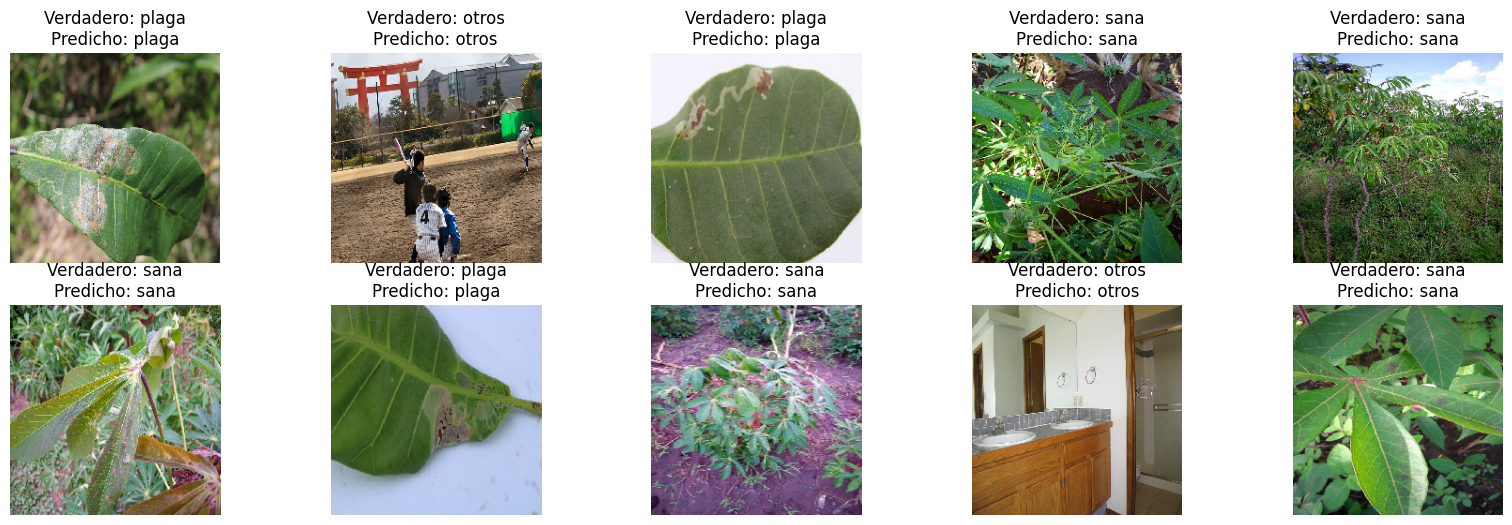

In [38]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar 10 índices aleatorios del conjunto de validación
indices = random.sample(range(len(X_val)), 10)

# Etiquetas de las clases
class_names = ['plaga', 'sana', 'otros']

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    # Expandir dims para predecir (batch=1)
    img_input = np.expand_dims(img, axis=0)
    pred_probs = model.model.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    # Mostrar imagen
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [39]:
model.save('modelo_resnet_multiclase_v2.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


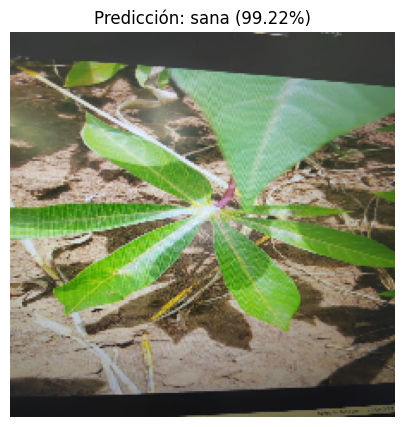

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [0.00344348 0.9922376  0.00431885]
Predicción final: sana con probabilidad 0.9922


In [41]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

# Carga el modelo desde el archivo .h5
modelo_cargado = load_model('modelo_resnet_multiclase_v2.h5')

img_path = 'Otros\\e1bfef98-e852-4c1b-a5bb-ce16ba72a49a.jpg'

# Etiquetas de las clases
clases = ['plaga', 'sana', 'otros']

# 1️⃣ Cargar imagen y redimensionar
img = image.load_img(img_path, target_size=(224, 224))

# 2️⃣ Convertir imagen a array numpy
img_array = image.img_to_array(img)

# 3️⃣ Expandir dimensiones para batch y normalizar
img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

# 4️⃣ Predecir con el modelo cargado (modelo_test debe estar cargado)
prediccion = modelo_cargado.predict(img_array_expanded)

# 5️⃣ Obtener índice de la clase con mayor probabilidad
indice_clase = np.argmax(prediccion[0])

# 6️⃣ Obtener etiqueta y probabilidad
etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

# 7️⃣ Mostrar imagen y resultado
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

# 8️⃣ Mostrar detalles en consola
print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")